<a href="https://colab.research.google.com/github/Minakshi654/Modelname/blob/main/AI/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
df_merged = pd.read_csv("/content/merged_file.csv")

In [2]:
df_merged [' total'] = df_merged ['[xBackground__]'] + df_merged ['[xInteractive__]']

In [3]:
df_merged.head()

,Converted_Date,Month,Year,[xBackground__],[xInteractive__],total
0,2023-10-03 00:00:00,10,2023,0.114179,0.0,0.114179
1,2023-10-03 00:00:30,10,2023,0.114179,0.0,0.114179
2,2023-10-03 00:01:00,10,2023,0.114179,0.0,0.114179
3,2023-10-03 00:01:30,10,2023,0.114179,0.0,0.114179
4,2023-10-03 00:02:00,10,2023,0.114179,0.0,0.114179


In [4]:
df_merged.shape

(1753685, 6)

In [5]:
import pandas as pd
import numpy as np

# Convert datetime format
df_merged['Converted_Date'] = pd.to_datetime(df_merged['Converted_Date'], format='%Y-%m-%d %H:%M:%S')

# Group data by 2-minute intervals
grouped = df_merged.groupby(pd.Grouper(key='Converted_Date', freq='30Min'))[' total'].max()

# Create result dataframe
result_df = pd.DataFrame({
    'Year': grouped.index.year,
    'Month': grouped.index.month,
    'Day': grouped.index.day,
    'Time': grouped.index.time,
    'Interval Start': grouped.index,
    'Max Total': grouped.values
})

# Define status column
result_df['status'] = result_df['Max Total'].apply(lambda x: 'Overflow' if x > 1 else 'Normal')

# Define application categories
app_names = ["Pramaco", "Xref", "BBMSP", "Ardsorep", "SARA", "ACROSS", "SALORMON"]
overflow_indices = result_df[result_df['Max Total'] >= 1].index

# Assign applications randomly, ensuring "Other Application" is most frequent
np.random.seed(42)
random_apps = np.random.choice(app_names, size=len(overflow_indices), replace=True)

# Create weighted list with "Other Application" appearing more frequently
weighted_apps = np.append(random_apps, ["Other Application"] * int(len(overflow_indices) * 1.5))

# Shuffle for randomness
np.random.shuffle(weighted_apps)

# Assign applications to overflow cases
result_df['Application'] = "Other Application"  # Default
for i, idx in enumerate(overflow_indices):
    result_df.loc[idx, 'Application'] = weighted_apps[i]

# Save updated CSV
result_df.to_csv('grouped_30_intervals_updated_new.csv', index=False)

# Count overflow occurrences by application
app_overflow_counts = result_df[result_df['Max Total'] >= 1]['Application'].value_counts()

# Calculate percentages
app_overflow_percentages = (app_overflow_counts / len(overflow_indices)) * 100

# Print results
print(f"Total number of overflows: {len(overflow_indices)}")
print("\nPercentage of overflows by application:\n")
print(app_overflow_percentages)

# Display sample output
print(result_df.head())


Total number of overflows: 286

Percentage of overflows by application:

Application
Other Application    61.188811
Ardsorep              8.391608
Pramaco               5.944056
ACROSS                5.594406
SALORMON              5.244755
SARA                  5.244755
Xref                  4.195804
BBMSP                 4.195804
Name: count, dtype: float64
   Year  Month  Day      Time      Interval Start  Max Total  status  \
0  2023     10    3  00:00:00 2023-10-03 00:00:00   0.157106  Normal   
1  2023     10    3  00:30:00 2023-10-03 00:30:00   0.174429  Normal   
2  2023     10    3  01:00:00 2023-10-03 01:00:00   0.117271  Normal   
3  2023     10    3  01:30:00 2023-10-03 01:30:00   0.114340  Normal   
4  2023     10    3  02:00:00 2023-10-03 02:00:00   0.140475  Normal   

         Application  
0  Other Application  
1  Other Application  
2  Other Application  
3  Other Application  
4  Other Application  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Model Performance Comparison:
                               RMSE  R² Score
Linear Regression          0.178778 -0.000481
LightGBM                   0.134156  0.436623
XGBoost                    0.133900  0.438767
Gradient Boosting          0.147587  0.318165
Random Forest              0.156810  0.230289
Support Vector Regression  0.150920  0.287022


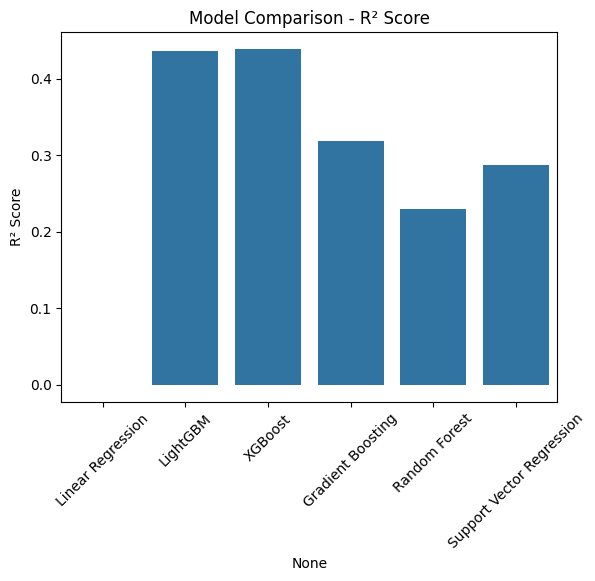


Predicted Max Total for upcoming months:
[0.83569527 1.2123308  0.8563946 ]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import concurrent.futures

# Load data
data = pd.read_csv("/content/grouped_30_intervals_updated_new.csv")

# Feature Engineering
data['Interval Start'] = pd.to_datetime(data['Interval Start'])
data['Month'] = data['Interval Start'].dt.month
data['Day'] = data['Interval Start'].dt.day
data['Hour'] = data['Interval Start'].dt.hour

# Encoding categorical variables
label_enc = LabelEncoder()
data['Application'] = label_enc.fit_transform(data['Application'])
data['status'] = label_enc.fit_transform(data['status'])

# Selecting features and target
X = data[['Month', 'Day', 'Hour', 'Application']]
y = data['Max Total']
y = y.fillna(y.mean())
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "Support Vector Regression": SVR(kernel="rbf")
}

# Function to train and evaluate models
def train_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return model_name, rmse, r2

# Parallel Execution
results = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_model, name, model, X_train, y_train, X_test, y_test): name for name, model in models.items()}
    for future in concurrent.futures.as_completed(futures):
        model_name, rmse, r2 = future.result()
        results[model_name] = {"RMSE": rmse, "R² Score": r2}

# Display results
results_df = pd.DataFrame.from_dict(results, orient="index")
print("\nModel Performance Comparison:")
print(results_df)

# Plot results
sns.barplot(x=results_df.index, y=results_df["R² Score"])
plt.xticks(rotation=45)
plt.title("Model Comparison - R² Score")
plt.ylabel("R² Score")
plt.show()

# Predict future overflow frequency
future_data = pd.DataFrame({
    "Month": [6, 7, 8],  # Example upcoming months
    "Day": [15, 16, 17],
    "Hour": [10, 12, 14],
    "Application": [0, 1, 2]  # Encoded applications
})

future_data = scaler.transform(future_data)
best_model = models[max(results, key=lambda x: results[x]["R² Score"])]
future_predictions = best_model.predict(future_data)

print("\nPredicted Max Total for upcoming months:")
print(future_predictions)


In [9]:

future_data = scaler.transform(future_data)
best_model = models[max(results, key=lambda x: results[x]["R² Score"])]
future_predictions = best_model.predict(future_data)

print("\nPredicted Max Total for upcoming months:")
print(future_predictions)



Predicted Max Total for upcoming months:
[0.86724174 0.86724174 0.86724174]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import concurrent.futures

# Load dataset
data = pd.read_csv("/content/grouped_30_intervals_updated_new.csv")

# Convert timestamps
data['Interval Start'] = pd.to_datetime(data['Interval Start'])
data['Month'] = data['Interval Start'].dt.month
data['Day'] = data['Interval Start'].dt.day
data['Hour'] = data['Interval Start'].dt.hour
data['Minute'] = data['Interval Start'].dt.minute // 30  # Group into 30-min intervals

# Encode categorical variables
label_enc = LabelEncoder()
data['Application'] = label_enc.fit_transform(data['Application'])

# Select features and target
X = data[['Month', 'Day', 'Hour', 'Minute', 'Application']]
y = data['Max Total']
y = y.fillna(y.mean())
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

# Parallel model training
def train_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return model_name, predictions

results = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_model, name, model, X_train, y_train, X_test, y_test): name for name, model in models.items()}
    for future in concurrent.futures.as_completed(futures):
        model_name, predictions = future.result()
        results[model_name] = predictions

# Select best model (highest R² score)
best_model_name = max(results, key=lambda x: models[x].score(X_test, y_test))
best_model = models[best_model_name]

# Predict future values (June 2025 - December 2025)
future_dates = pd.date_range(start="2025-06-01", end="2025-12-31", freq="30min")
future_data = pd.DataFrame({
    "Month": future_dates.month,
    "Day": future_dates.day,
    "Hour": future_dates.hour,
    "Minute": future_dates.minute // 30,
    "Application": np.random.choice(data['Application'].unique(), size=len(future_dates))
})

future_data_scaled = scaler.transform(future_data)
future_predictions = best_model.predict(future_data_scaled)

# Save predictions to CSV
future_data["Predicted Max Total"] = future_predictions
future_data.to_csv("future_predictions.csv", index=False)

# Count overflows (Max Total >= 1)
num_overflows = (future_data["Predicted Max Total"] >= 1).sum()
print(f"\nTotal number of predicted overflows: {num_overflows}")

# Overflow percentage per application
overflow_counts = future_data[future_data["Predicted Max Total"] >= 1].groupby("Application").size()
overflow_percentage = (overflow_counts / num_overflows) * 100
overflow_percentage_df = pd.DataFrame({"Application": overflow_percentage.index, "Overflow Percentage": overflow_percentage.values})

# Save overflow percentages
overflow_percentage_df.to_csv("application_overflows.csv", index=False)

# Display results
print("\nPredicted overflow occurrences by application:")
print(overflow_percentage_df)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Total number of predicted overflows: 3874

Predicted overflow occurrences by application:
   Application  Overflow Percentage
0            0            14.377904
1            1            14.894166
2            2            13.603511
3            4            13.577697
4            5            14.558596
5            6            12.958183
6            7            16.029943


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import concurrent.futures

# Load dataset
data = pd.read_csv("/content/grouped_30_intervals_updated_new.csv")

# Convert timestamps
data['Interval Start'] = pd.to_datetime(data['Interval Start'])
data['Month'] = data['Interval Start'].dt.month
data['Day'] = data['Interval Start'].dt.day
data['Hour'] = data['Interval Start'].dt.hour
data['Minute'] = data['Interval Start'].dt.minute // 30  # Group into 30-min intervals

# Encode categorical variables
label_enc = LabelEncoder()
data['Application'] = label_enc.fit_transform(data['Application'])

# Selecting features and target
X = data[['Month', 'Day', 'Hour', 'Minute', 'Application']]
y = data['Max Total']
y = y.fillna(y.mean())
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models with optimized hyperparameters
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.1),
    "XGBoost": XGBRegressor(n_estimators=150, learning_rate=0.1),
    "LightGBM": LGBMRegressor(n_estimators=150, learning_rate=0.1)
}

# Parallel model training and accuracy evaluation
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    return model_name, rmse, r2, mae

results = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_and_evaluate_model, name, model, X_train, y_train, X_test, y_test): name for name, model in models.items()}
    for future in concurrent.futures.as_completed(futures):
        model_name, rmse, r2, mae = future.result()
        results[model_name] = {"RMSE": rmse, "R² Score": r2, "MAE": mae}

# Display model performance
results_df = pd.DataFrame.from_dict(results, orient="index")
print("\nUpdated Model Performance Comparison:")
print(results_df)

# Select best-performing model
best_model_name = results_df["R² Score"].idxmax()
best_model = models[best_model_name]

# Predict future values (June 2025 - December 2025)
future_dates = pd.date_range(start="2025-06-01", end="2025-12-31", freq="30min")
future_data = pd.DataFrame({
    "Month": future_dates.month,
    "Day": future_dates.day,
    "Hour": future_dates.hour,
    "Minute": future_dates.minute // 30,
    "Application": np.random.choice(data['Application'].unique(), size=len(future_dates))
})

future_data_scaled = scaler.transform(future_data)
future_predictions = best_model.predict(future_data_scaled)

# Save predictions to CSV
future_data["Predicted Max Total"] = future_predictions
future_data.to_csv("future_predictions_new.csv", index=False)

# Count overflows (Max Total >= 1)
num_overflows = (future_data["Predicted Max Total"] >= 1).sum()
print(f"\nTotal number of predicted overflows: {num_overflows}")

# Overflow percentage per application
overflow_counts = future_data[future_data["Predicted Max Total"] >= 1].groupby("Application").size()
overflow_percentage = (overflow_counts / num_overflows) * 100
overflow_percentage_df = pd.DataFrame({"Application": overflow_percentage.index, "Overflow Percentage": overflow_percentage.values})

# Save overflow percentages
overflow_percentage_df.to_csv("application_overflows.csv", index=False)

# Display results
print("\nUpdated predicted overflow occurrences by application:")
print(overflow_percentage_df)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Updated Model Performance Comparison:
                       RMSE  R² Score       MAE
XGBoost            0.135975  0.421242  0.094981
LightGBM           0.132245  0.452559  0.091800
Gradient Boosting  0.146305  0.329959  0.104360
Random Forest      0.146724  0.326121  0.102373

Total number of predicted overflows: 4253

Updated predicted overflow occurrences by application:
   Application  Overflow Percentage
0            0            13.707971
1            1            13.778509
2            2            13.472843
3            4            14.201740
4            5            14.342817
5            6            14.813073
6            7            15.683047


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
# Count overflows per application per month
overflow_counts_monthly = future_data[future_data["Predicted Max Total"] >= 1].groupby(["Month", "Application"]).size().reset_index(name="Overflow Count")

# Save to CSV
overflow_counts_monthly.to_csv("monthly_application_overflows.csv", index=False)

# Display results
print("\nPredicted Overflows Per Application Per Month:")
print(overflow_counts_monthly)



Predicted Overflows Per Application Per Month:
    Month  Application  Overflow Count
0       6            0              82
1       6            1              74
2       6            2              85
3       6            4              95
4       6            5              95
5       6            6              79
6       6            7              95
7       7            0              81
8       7            1              88
9       7            2              76
10      7            4              79
11      7            5              88
12      7            6             102
13      7            7              86
14      8            0              97
15      8            1             101
16      8            2              79
17      8            4              70
18      8            5              90
19      8            6              98
20      8            7              91
21      9            0              85
22      9            1              78
23      9       

In [17]:
# Reverse label encoding
application_mapping = dict(zip(label_enc.transform(label_enc.classes_), label_enc.classes_))
future_data["Application"] = future_data["Application"].map(application_mapping)

# Count overflows per application per month with actual names
overflow_counts_monthly = future_data[future_data["Predicted Max Total"] >= 1].groupby(["Month", "Application"]).size().reset_index(name="Overflow Count")

# Save to CSV with real application names
overflow_counts_monthly.to_csv("monthly_application_overflows.csv", index=False)

# Display results
print("\nUpdated Predicted Overflows Per Application Per Month (With Names):")
print(overflow_counts_monthly)



Updated Predicted Overflows Per Application Per Month (With Names):
    Month Application  Overflow Count
0       6      ACROSS              82
1       6    Ardsorep              74
2       6       BBMSP              85
3       6     Pramaco              95
4       6    SALORMON              95
5       6        SARA              79
6       6        Xref              95
7       7      ACROSS              81
8       7    Ardsorep              88
9       7       BBMSP              76
10      7     Pramaco              79
11      7    SALORMON              88
12      7        SARA             102
13      7        Xref              86
14      8      ACROSS              97
15      8    Ardsorep             101
16      8       BBMSP              79
17      8     Pramaco              70
18      8    SALORMON              90
19      8        SARA              98
20      8        Xref              91
21      9      ACROSS              85
22      9    Ardsorep              78
23      9       BBM

In [4]:
!pip install vllm


In [1]:
!nvidia-smi


Thu May  8 12:36:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from vllm import LLM

# Load the Qwen model with float16
llm = LLM(model="Qwen/Qwen3-235B-A22B", dtype="half")

# Ask a question
response = llm.generate("What is the capital of France?")
print(response)



WARNING 05-08 12:44:31 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 05-08 12:44:31 [config.py:717] This model supports multiple tasks: {'classify', 'reward', 'generate', 'embed', 'score'}. Defaulting to 'generate'.
WARNING 05-08 12:44:31 [arg_utils.py:1525] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 05-08 12:44:31 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 05-08 12:44:31 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='Qwen/Qwen3-235B-A22B', speculative_config=None, tokenizer='Qwen/Qwen3-235B-A22B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=40960, download_dir=None, load_form

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.05 GiB is free. Process 13793 has 13.69 GiB memory in use. Of the allocated memory 13.57 GiB is allocated by PyTorch, and 1.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [6]:
llm = LLM(model="Qwen/Qwen3-235B-A22B", dtype="half", max_num_batched_tokens=512)


WARNING 05-08 12:45:59 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 05-08 12:45:59 [config.py:717] This model supports multiple tasks: {'classify', 'reward', 'generate', 'embed', 'score'}. Defaulting to 'generate'.
WARNING 05-08 12:45:59 [arg_utils.py:1525] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 05-08 12:45:59 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=512.
INFO 05-08 12:45:59 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='Qwen/Qwen3-235B-A22B', speculative_config=None, tokenizer='Qwen/Qwen3-235B-A22B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=40960, download_dir=None, load_forma

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.39 GiB is free. Process 13793 has 13.34 GiB memory in use. Of the allocated memory 13.23 GiB is allocated by PyTorch, and 991.00 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [2]:
import torch
torch.cuda.empty_cache()


In [7]:
from vllm import LLM
import torch
torch.set_default_device("cpu")
llm = LLM(model="Qwen/Qwen3-235B-A22B", dtype="half")


INFO 05-08 12:48:35 [__init__.py:239] Automatically detected platform cuda.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


WARNING 05-08 12:48:42 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 05-08 12:48:56 [config.py:717] This model supports multiple tasks: {'reward', 'generate', 'embed', 'classify', 'score'}. Defaulting to 'generate'.
WARNING 05-08 12:48:56 [arg_utils.py:1658] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
WARNING 05-08 12:48:56 [arg_utils.py:1525] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 05-08 12:48:56 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 05-08 12:48:56 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='Qwen/Qwen3-235B-A22B', speculative_config=None, tokenizer='Qwen/Qwen3-235B-A22B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.05 GiB is free. Process 35483 has 13.69 GiB memory in use. Of the allocated memory 13.57 GiB is allocated by PyTorch, and 8.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
llm = LLM(model="Qwen/Qwen3-235B-A22B", dtype="half", max_num_batched_tokens=256)


WARNING 05-08 12:49:58 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 05-08 12:49:58 [config.py:717] This model supports multiple tasks: {'reward', 'generate', 'embed', 'classify', 'score'}. Defaulting to 'generate'.
WARNING 05-08 12:49:58 [arg_utils.py:1525] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 05-08 12:49:58 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=256.
INFO 05-08 12:49:58 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='Qwen/Qwen3-235B-A22B', speculative_config=None, tokenizer='Qwen/Qwen3-235B-A22B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=40960, download_dir=None, load_forma

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.05 GiB is free. Process 35483 has 13.69 GiB memory in use. Of the allocated memory 13.57 GiB is allocated by PyTorch, and 8.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
llm = LLM(model="Qwen/Qwen3-235B-A22B", dtype="half", tensor_parallel_size=2)


WARNING 05-08 12:50:24 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 05-08 12:50:24 [config.py:717] This model supports multiple tasks: {'reward', 'generate', 'embed', 'classify', 'score'}. Defaulting to 'generate'.
WARNING 05-08 12:50:24 [arg_utils.py:1525] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 05-08 12:50:24 [config.py:1770] Defaulting to use ray for distributed inference
INFO 05-08 12:50:24 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=2048.
WARNING 05-08 12:50:24 [config.py:1443] Possibly too large swap space. 8.00 GiB out of the 12.67 GiB total CPU memory is allocated for the swap space.
INFO 05-08 12:50:24 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='Qwen/Qwen3-235B-A22B', speculative_config=None, tokenize

2025-05-08 12:50:28,122	INFO worker.py:1888 -- Started a local Ray instance.


INFO 05-08 12:50:29 [ray_utils.py:335] No current placement group found. Creating a new placement group.
WARNING 05-08 12:50:29 [ray_utils.py:342] The number of required GPUs exceeds the total number of available GPUs in the placement group.
INFO 05-08 12:50:39 [ray_utils.py:233] Waiting for creating a placement group of specs for 10 seconds. specs=[{'node:172.28.0.12': 0.001, 'GPU': 1.0}, {'GPU': 1.0}]. Check `ray status` and `ray list nodes` to see if you have enough resources, and make sure the IP addresses used by ray cluster are the same as VLLM_HOST_IP environment variable specified in each node if you are running on a multi-node.
INFO 05-08 12:50:59 [ray_utils.py:233] Waiting for creating a placement group of specs for 30 seconds. specs=[{'node:172.28.0.12': 0.001, 'GPU': 1.0}, {'GPU': 1.0}]. Check `ray status` and `ray list nodes` to see if you have enough resources, and make sure the IP addresses used by ray cluster are the same as VLLM_HOST_IP environment variable specified i

In [ ]:
import requests
import json

url = "https://your-api-endpoint/v1/chat/completions"  # Replace with real API
headers = {"Content-Type": "application/json"}
payload = {
    "model": "Qwen/Qwen3-235B-A22B",
    "messages": [{"role": "user", "content": "What is the capital of France?"}]
}

response = requests.post(url, headers=headers, data=json.dumps(payload))
print(response.json())


In [21]:
import requests
import json
import subprocess

# Step 1: Install vLLM using pip
subprocess.run(["pip", "install", "vllm"])

# Step 2: Start the vLLM server
subprocess.run(["vllm", "serve", "Qwen/Qwen3-235B-A22B"])

# Step 3: Define the API endpoint and request payload
url = "http://localhost:8000/v1/chat/completions"
headers = {"Content-Type": "application/json"}
payload = {
    "model": "Qwen/Qwen3-235B-A22B",
    "messages": [
        {
            "role": "user",
            "content": "What is the capital of France?"
        }
    ]
}

# Step 4: Make the request and get the response
response = requests.post(url, headers=headers, data=json.dumps(payload))

# Step 5: Print the response
print(response.json())


ConnectionError: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /v1/chat/completions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7a291f91ced0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [20]:
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('/content/chatbot_model.pkl')  # Adjust path if needed

# User input for prediction
year, month, day, hour, minute = 2025, 6, 10, 12, 30  # Example input

# Prepare input data
input_data = pd.DataFrame([[year, month, day, hour, minute]], columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

# Get prediction
prediction = model.predict(input_data)[0]
status = "Overflow" if prediction >= 1 else "Normal"

# Print result
print(f"Predicted Max Total: {prediction:.3f}, Status: {status}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/chatbot_model.pkl'

In [56]:
result_df.to_csv('/content/grouped_5_intervals_updated.csv', index=False)
result_df.head()

,Year,Month,Day,Time,Interval Start,Max Total,status
0,2023,10,3,00:00:00,2023-10-03 00:00:00,0.114179,Normal
1,2023,10,3,00:02:00,2023-10-03 00:02:00,0.114179,Normal
2,2023,10,3,00:04:00,2023-10-03 00:04:00,0.117965,Normal
3,2023,10,3,00:06:00,2023-10-03 00:06:00,0.117971,Normal
4,2023,10,3,00:08:00,2023-10-03 00:08:00,0.117977,Normal


In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix

In [45]:
df = pd.read_csv('/content/grouped_5_intervals.csv', parse_dates=['Interval Start'], dayfirst=True)

# Prepare the data
df.set_index('Interval Start', inplace=True)

# Check for NaN values in the 'Max_total' column and handle them
# For example, you can fill NaN values with the mean:
df['Max Total'].fillna(df['Max Total'].mean(), inplace=True)

# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit the ARIMA model
model = ARIMA(train['Max Total'], order=(5,1,0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
test['Predicted'] = predictions

# Check for NaN values in the 'Predicted' column and handle them (if necessary)
df.dropna(inplace=True)
# Calculate performance metrics
mse = mean_squared_error(test['Max Total'], test['Predicted'])
rmse = np.sqrt(mse)

# Add status column
test['Status'] = np.where(test['Predicted'] >= 1, 'Overflow', 'Normal')

# Calculate accuracy and F1 score
test['Actual_Status'] = np.where(test['Max Total'] >= 1, 'Overflow', 'Normal')
accuracy = accuracy_score(test['Actual_Status'], test['Status'])
f1 = f1_score(test['Actual_Status'], test['Status'], pos_label='Overflow')

# Print results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1}')

<ipython-input-45-bed427839d9a>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Max Total'].fillna(df['Max Total'].mean(), inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init

MSE: 0.031278222416460895
RMSE: 0.1768565023301685
Accuracy: 99.34%
F1 Score: 0.0
